<a href="https://colab.research.google.com/github/VenissaCarolQuadros/COMP551/blob/report/COMP551_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_data(url, dest):
  response = requests.get(url)
  with open(dest, 'wb') as file:
      file.write(response.content)
  return

In [3]:
dest1= 'LinearRegression.xlsx'
read_data("https://raw.githubusercontent.com/VenissaCarolQuadros/COMP551/main/data/ENB2012_data.xlsx", dest1)
df1= pd.read_excel(dest1)
df1.columns = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

dest2= 'LogisticRegression.csv'
read_data('https://raw.githubusercontent.com/VenissaCarolQuadros/COMP551/main/data/Qualitative_Bankruptcy/Qualitative_Bankruptcy.data.txt', dest2)
df2= pd.read_csv(dest2, header=None)


In [4]:
print("Verifying shape of df1:", df1.shape, "\nVerifying shape of df2:", df2.shape) ##Verifying dataset size
print( "Checking for nulls in df1:", df1[df1.eq('?').any(1)])
print("Checking for nulls in df1:", df2[ df2.eq('?').any(1)]) #Checking for nulls
##No nulls found. Dataset size seems right

Verifying shape of df1: (768, 10) 
Verifying shape of df2: (250, 7)
Checking for nulls in df1: Empty DataFrame
Columns: [relative_compactness, surface_area, wall_area, roof_area, overall_height, orientation, glazing_area, glazing_area_distribution, heating_load, cooling_load]
Index: []
Checking for nulls in df1: Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6]
Index: []


##Gradient Descent

In [15]:

class GradientDescent:
    
    def __init__(self, learning_rate=.0001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
        self.cost_history=[]
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad, cost = gradient_fn(x, y, w)               # compute the gradient with present weight
            self.cost_history.append(cost)
            w = w - self.learning_rate * grad         # weight update step
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

In [57]:
class StochasticGradientDescent:
    
    def __init__(self, learning_rate=.0001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
        self.cost_history=[]
          
    def run(self, gradient_fn, x, y, w, batch_size):
        learning_rate=self.learning_rate
        grad = np.inf
        t = 1
        instance=0
        while t < self.max_iters:
            mini_batches =self.create_mini_batches(x, y, batch_size)
            for mini_batch in mini_batches:
                x_mini, y_mini= mini_batch
                grad, cost = gradient_fn(x_mini, y_mini, w)
                self.cost_history.append(cost)
                w = w - learning_rate * grad         # weight update step
                if self.record_history:
                    self.w_history.append(w)
                learning_rate=self.learning_rate/t
            t += 1
        return w

    def create_mini_batches(self, x, y, batch_size):
      mini_batches = []
      if len(y.shape)==1:
        y=y[:, np.newaxis]
      data = np.hstack((x, y))
      #print(x.shape, y.shape)
      np.random.shuffle(data)
      n_minibatches = data.shape[0] // batch_size
      i = 0
  
      for i in range(n_minibatches + 1):
          mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
          X_mini = mini_batch[:, :-(y.shape[1])]
          Y_mini = mini_batch[:, (X_mini.shape[1]):]
          #print(X_mini.shape, Y_mini.shape)
          mini_batches.append((X_mini, Y_mini))
      if data.shape[0] % batch_size != 0:
          mini_batch = data[i * batch_size:data.shape[0]]
          X_mini = mini_batch[:, :-(y.shape[1])]
          Y_mini = mini_batch[:, (X_mini.shape[1]):]
          #print(X_mini.shape, Y_mini.shape)
          mini_batches.append((X_mini, Y_mini))
      return mini_batches

##Linear Regression

In [77]:
class LinearRegression:
  def __init__(self):
    ()
  
  def editData(self):
    self.X= np.c_[np.ones((self.X).shape[0]), (self.X)] 
    return
  
  def fitClosedForm(self, X, Y):
    self.X=X
    self.Y=Y
    self.editData()
    self.w= np.linalg.inv((self.X).T @ (self.X))@ (self.X).T@ (self.Y)
    #print(self.w)
    return self.w

  def fitGD(self, X, Y, optimizer):#, optimizer2):
      self.X=X
      self.Y=Y
      self.editData()
      self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))
      def gradient(x, y, w):                          # define the gradient function
          yh =  x @ w 
          N, D = x.shape
          grad = (x.T@ (yh - y))/N
          return grad, .5*np.mean((yh - y)**2)
      self.w = optimizer.run(gradient, self.X, self.Y, self.w)      
      return self.w

  def fitSGD(self, X, Y, optimizer, batch_size):
      self.X=X
      self.Y=Y
      self.editData()
      self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))
      def gradient(x, y, w):                          # define the gradient function
          yh =  x @ w
          grad = (x.T@ (yh - y))/(batch_size)
          return grad, .5*np.mean((yh - y)**2)
      self.w = optimizer.run(gradient, self.X, self.Y, self.w, batch_size)
      return self.w

  def predict(self, Xt):
    Xt= np.c_[np.ones((Xt).shape[0]), (Xt)] 
    return Xt @ self.w
  
  

##Logistic Regression

In [86]:
logistic = lambda z: 1./ (1 + np.exp(-z))
class LogisticRegression:
  
  def editData(self):
    self.X= np.c_[np.ones((self.X).shape[0]), (self.X)] 
    return

  def fitGD(self, X, Y, optimizer):
      self.X= X
      self.Y= Y#np.squeeze(Y)
      self.editData()
      def gradient(x, y, w):
          N,D = x.shape
          yh = logistic(x @ w)   # predictions  size N
          grad = (x.T@ (yh - y))/N#np.dot(yh-y, x)/N
          return grad, self.cost_fn(x,y,w)
      #w0 = np.zeros(self.X.shape[1])                            # initialize the weights
      #print(self.X.shape, w0.shape) 
      self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))  
      self.w = optimizer.run(gradient, self.X, self.Y, self.w)      # run the optimizer to get the optimal weights
      return self.w

  def fitSGD(self, X, Y, optimizer, batch_size):
    self.X= X
    self.Y= Y#np.squeeze(Y)
    self.editData()
    def gradient(x, y, w):
        yh = logistic(x @ w)   # predictions  size N
        grad = (x.T@ (yh - y))/(batch_size)
        return grad, self.cost_fn(x,y,w)
    self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))                            # initialize the weights
    self.w = optimizer.run(gradient, self.X, self.Y, self.w, batch_size)      # run the optimizer to get the optimal weights
    return self.w

  def cost_fn(self, x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J =np.mean(np.squeeze(y) * np.squeeze(np.log1p(np.exp(-z))) + (1-np.squeeze(y)) * np.squeeze(np.log1p(np.exp(z)))) #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

  def predict(self, Xt):
    Xt= np.c_[np.ones((Xt).shape[0]), (Xt)] 
    return logistic(Xt @ self.w)
 

##Cross Validate

In [88]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

## Data Analysis

<Figure size 360x360 with 0 Axes>

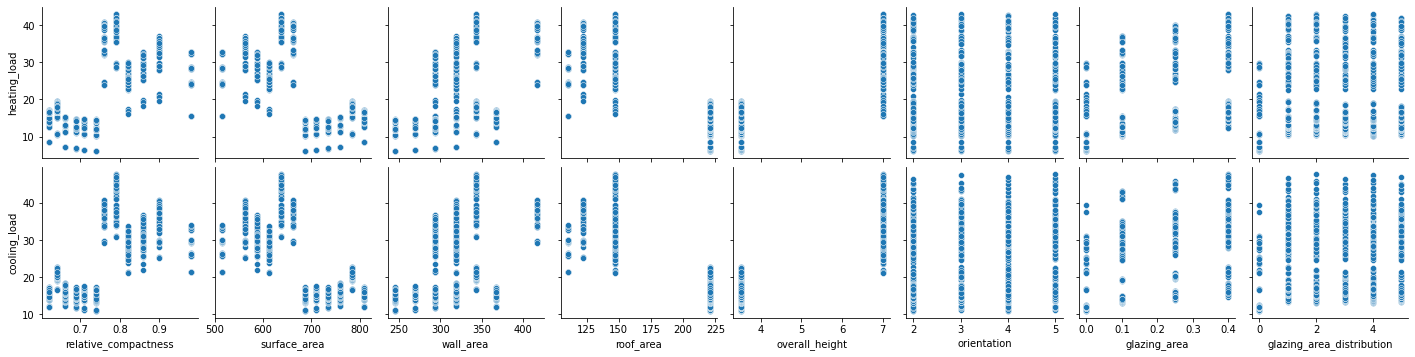

Statistical Description:        relative_compactness  surface_area   wall_area   roof_area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167    671.708333  318.500000  176.604167   
std                0.105777     88.086116   43.626481   45.165950   
min                0.620000    514.500000  245.000000  110.250000   
25%                0.682500    606.375000  294.000000  140.875000   
50%                0.750000    673.750000  318.500000  183.750000   
75%                0.830000    741.125000  343.000000  220.500000   
max                0.980000    808.500000  416.500000  220.500000   

       overall_height  orientation  glazing_area  glazing_area_distribution  \
count       768.00000   768.000000    768.000000                  768.00000   
mean          5.25000     3.500000      0.234375                    2.81250   
std           1.75114     1.118763      0.133221                    1.55096   
min           3.50000     2.000000   

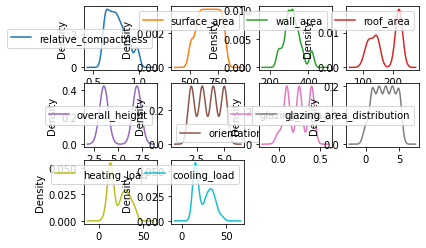

In [60]:
plt.figure(figsize=(5,5))
sns.pairplot(data=df1, y_vars=['heating_load', 'cooling_load'], x_vars=['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution'])
plt.show()

df1.plot(kind='density', subplots=True, layout=(3,4), sharex=False, sharey=False)

print("Statistical Description:", df1.describe())
print("Correlation:", df1.corr(method='pearson'))

In [62]:
## Encoding for categorical data
data2= df2.copy(deep=True)
data2[6].replace(['NB', 'B'], [0, 1], inplace=True)
for i in range(6):
  data2[i].replace(['N', 'A', 'P'], [-1, 0, 1], inplace=True)
data2.head()

,0,1,2,3,4,5,6
0,1,1,0,0,0,1,0
1,-1,-1,0,0,0,-1,0
2,0,0,0,0,0,0,0
3,1,1,1,1,1,1,0
4,-1,-1,1,1,1,-1,0


Statistical Description:                 0          1           2           3           4          5  \
count  250.000000  250.00000  250.000000  250.000000  250.000000  250.00000   
mean    -0.036000   -0.22800   -0.248000   -0.060000   -0.048000   -0.14000   
std      0.823051    0.82141    0.803166    0.831363    0.881364    0.86915   
min     -1.000000   -1.00000   -1.000000   -1.000000   -1.000000   -1.00000   
25%     -1.000000   -1.00000   -1.000000   -1.000000   -1.000000   -1.00000   
50%      0.000000    0.00000    0.000000    0.000000    0.000000    0.00000   
75%      1.000000    0.00000    0.000000    1.000000    1.000000    1.00000   
max      1.000000    1.00000    1.000000    1.000000    1.000000    1.00000   

                6  
count  250.000000  
mean     0.428000  
std      0.495781  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000  
Correlation:           0         1         2         3         4         5         

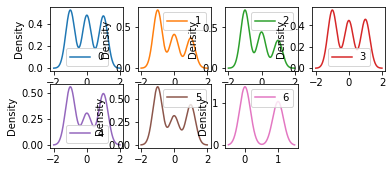

In [65]:
data2.plot(kind='density', subplots=True, layout=(3,4), sharex=False, sharey=False)

print("Statistical Description:", data2.describe())
print("Correlation:", data2.corr())

##Experiments

In [81]:
#Train test split

data1= df1.copy(deep=True)
data1.drop(columns=['orientation','glazing_area_distribution'], inplace=True)

train=data1.sample(frac=0.8, random_state=200)
test=data1.drop(train.index)

X_train= train.iloc[:, :6].to_numpy(copy=True) 
X_train= X_train/ X_train.max(axis=0)
Y_train= train.iloc[:, 6:].to_numpy(copy=True)



X_test= test.iloc[:, :6].to_numpy(copy=True)
X_test= X_test/ X_test.max(axis=0)
Y_test= test.iloc[:, 6:].to_numpy(copy=True)



In [100]:
model1= LinearRegression()
weights= model1.fitClosedForm(X_train, Y_train)
Ypredict=model1.predict(X_test)
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
Ypredict1=model1.predict(X_train)
loss1=0.5*np.mean((Y_train-Ypredict1)**2, axis=0)
print("MSE Cost for train set:", loss1)
print("MSE Cost for test set:", loss)
print("Weights:", weights)

MSE Cost for train set: [4.92897501 5.74132244]
MSE Cost for test set: [4.1553933  5.22406799]
Weights: [[ 77.41300271  87.1087861 ]
 [-59.61649399 -63.50757984]
 [ 27.9986531   32.8782761 ]
 [-23.87145009 -32.5232584 ]
 [-51.92585023 -53.59098091]
 [ 29.54952703  30.560237  ]
 [  8.26975338   5.99151998]]


In [103]:
train1=data2.sample(frac=0.8, random_state=200)
test1=data2.drop(train1.index)

X_train1= train1.iloc[:, :6].to_numpy(copy=True) 
Y_train1= train1.iloc[:, 6:].to_numpy(copy=True)

X_test1= test1.iloc[:, :6].to_numpy(copy=True) 
Y_test1= test1.iloc[:, 6:].to_numpy(copy=True)

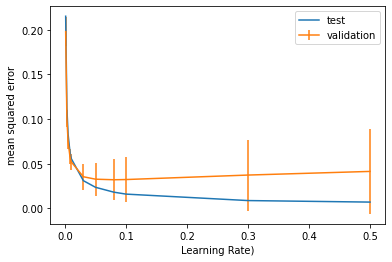

In [104]:
num_folds = 5
model = LogisticRegression()
learning_rates=[0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5]
err_test, err_valid = np.zeros(len(learning_rates)), np.zeros((len(learning_rates), num_folds))
for i, K in enumerate(learning_rates):
    for f, (tr, val) in enumerate(cross_validate(X_train1.shape[0], num_folds)):
        optimizer = GradientDescent(learning_rate=K, max_iters=5000, record_history=False)
        W = model.fitGD(X_train1[tr, :], Y_train1[tr, :], optimizer)
        err_valid[i, f] = model.cost_fn(np.c_[np.ones((X_train1[val]).shape[0]), (X_train1[val])] , np.squeeze(Y_train1[val]), W)
    params = model.fitGD(X_train1[tr, :], Y_train1[tr, :], optimizer)
    err_test[i]= model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), W)
    
plt.plot(learning_rates, err_test,  label='test')
plt.errorbar(learning_rates, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Learning Rate)')
plt.ylabel('mean squared error')
plt.show()

In [108]:
optimizer = GradientDescent(learning_rate=.03, max_iters=5000, record_history=False)#GradientDescent(learning_rate=.0003, max_iters=5000, record_history=False)
model= LogisticRegression()
W=model.fitGD(X_train1, Y_train1, optimizer)
Ypredict=model.predict(X_test1)
Ypredict1=model.predict(X_train1)
print("Weights:", W)
print("MSE Cost for train set:", model.cost_fn(np.c_[np.ones((X_train1).shape[0]), (X_train1)] , np.squeeze(Y_train1), W))
print("MSE Cost for test set:", model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), W))

Weights: [[-1.92565578]
 [-0.72190659]
 [-0.20429607]
 [-2.09209586]
 [-2.06759473]
 [-3.47068638]
 [-0.27956148]]
MSE Cost for train set: 0.023506164503018415
MSE Cost for test set: 0.03455612621372145


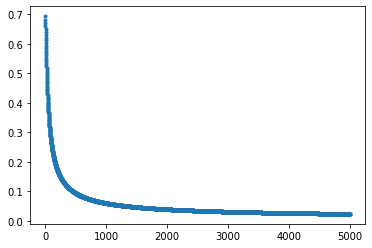

In [109]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(optimizer.cost_history)), optimizer.cost_history, '.')
plt.show()


##Analytical linear regression

## Gradient descent

#Full batch GD

In [12]:
optimizer = GradientDescent(learning_rate=0.1, max_iters=1e4, record_history=False)
model= LinearRegression()
model.fitGD(X_train, Y_train, optimizer)

In [13]:
Ypredict=model.predict(X_test)
#print(np.c_[Y_test, Ypredict])
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
print(loss)

[4.01000078 5.16858822]


##Stochastic

In [58]:
optimizer = StochasticGradientDescent(learning_rate=0.4, max_iters=1e4, record_history=False) 
model= LinearRegression()
model.fitSGD(X_train, Y_train, optimizer, 24)

In [59]:
Ypredict=model.predict(X_test)
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
print(loss)

[4.84312383 6.07646227]


In [ ]:
print(np.c_[Y_test, Ypredict])

##Confusion matrix

In [ ]:
def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix



## Logistic Regression

In [ ]:
df2.head()

,0,1,2,3,4,5,6
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB


In [ ]:
check_nan = df2.isnull().values.any()
print(check_nan)

False


In [ ]:
optimizer = StochasticGradientDescent(learning_rate=0.7, max_iters=5000, record_history=False)#GradientDescent(learning_rate=.0003, max_iters=5000, record_history=False)
model= LogisticRegression()
W=model.fitSGD(X_train, Y_train, optimizer, 10)
Ypredict=model.predict(X_test)
print(model.cost_fn(np.c_[np.ones((X_test).shape[0]), (X_test)] , np.squeeze(Y_test), W))

0.17124173220673


In [ ]:
cmat = confusion_matrix(Y_test, (Ypredict>0.5).astype(int))
print(cmat)
print(f'accuracy: {np.sum(np.diag(cmat))/np.sum(cmat)}')

[[28.  0.]
 [ 0. 22.]]
accuracy: 1.0


##Cross validation

In [ ]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

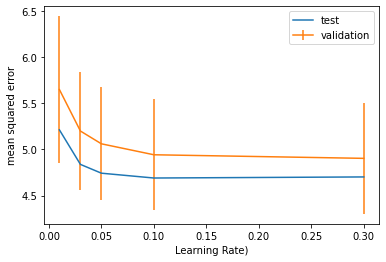

In [ ]:
loss = lambda y, yh: 0.5*np.mean((y-yh)**2)
num_folds = 5
model = LinearRegression()
learning_rates=[0.01, 0.03, 0.05, 0.1, 0.3]
err_test, err_valid = np.zeros(len(learning_rates)), np.zeros((len(learning_rates), num_folds))
for i, K in enumerate(learning_rates):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(X_train.shape[0], num_folds)):
        optimizer = GradientDescent(learning_rate=K, max_iters=1e4, record_history=False)
        #print(X_train.shape, X_train[tr, :].shape, Y_train.shape, Y_train[tr, :].shape)
        params = model.fitGD(X_train[tr, :], Y_train[tr, :], optimizer)
        err_valid[i, f] = loss(Y_train[val], model.predict(X_train[val]))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    params = model.fitGD(X_train[tr], Y_train[tr], optimizer)
    err_test[i]= loss(Y_test, model.predict(X_test))
    
plt.plot(learning_rates, err_test,  label='test')
plt.errorbar(learning_rates, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Learning Rate)')
plt.ylabel('mean squared error')
plt.show()